# Trafik İşareti Sınıflandırma Projesi (End-to-End)

Bu notebook, 3 aşamalı Python projesinin birleştirilmiş ve görselleştirilmiş halidir:
1. **Veri Ön İşleme:** Görüntüleri kırpma, boyutlandırma ve `.npy` olarak kaydetme.
2. **Model Eğitimi:** PyTorch ile CNN modeli kurma ve eğitme.
3. **Model Testi:** Eğitilen modeli test verisi üzerinde deneme ve karmaşıklık matrisi çizme.

---

In [5]:
# Gerekli kütüphaneleri ve ortam ayarlarını yapalım
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Grafikleri notebook içinde görebilmek için:
%matplotlib inline

print("Tüm kütüphaneler başarıyla yüklendi!")

Tüm kütüphaneler başarıyla yüklendi!


## BÖLÜM 1: Veri Ön İşleme (`veri_onisleme.py`)

Burada `Final_Training/Images` klasöründeki ham verileri alıp, ROI (Region of Interest) koordinatlarına göre kırpıp, 64x64 boyutuna getirip normalize edeceğiz.

In [ ]:

DATA_DIR = 'GTSRB/Images' 
IMG_SIZE = (64, 64)

def load_data_info(data_dir):
    print(f"'{data_dir}' dizininden veri bilgileri yükleniyor...")
    all_data_info = []
    
    try:
        class_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
        
        for class_id in sorted(class_folders):
            class_path = os.path.join(data_dir, class_id)
            csv_filename = f'GT-{class_id}.csv'
            csv_path = os.path.join(class_path, csv_filename)
            
            if not os.path.exists(csv_path):
                continue
            
            df = pd.read_csv(csv_path, sep=';')
            for index, row in df.iterrows():
                filename = row['Filename']
                image_path = os.path.join(class_path, filename)
                all_data_info.append([
                    image_path,
                    int(row['ClassId']),
                    int(row['Roi.X1']), int(row['Roi.Y1']), int(row['Roi.X2']), int(row['Roi.Y2'])
                ])
                
    except FileNotFoundError:
        print(f"HATA: Veri dizini '{data_dir}' bulunamadı.")
        return None
    except Exception as e:
        print(f"HATA: {e}")
        return None
        
    print(f"Toplam {len(all_data_info)} adet görüntünün bilgisi başarıyla yüklendi.")
    return all_data_info

def process_image(image_path, roi, target_size):
    try:
        image = cv2.imread(image_path)
        if image is None: return None

        x1, y1, x2, y2 = roi
        cropped_image = image[y1:y2, x1:x2]
        
        if cropped_image.shape[0] == 0 or cropped_image.shape[1] == 0: return None
            
        resized_image = cv2.resize(cropped_image, target_size)
        normalized_image = resized_image / 255.0
        return normalized_image
        
    except Exception as e:
        return None


data_info_list = load_data_info(DATA_DIR)

if data_info_list:
    X_data = [] 
    y_labels = [] 
    
    print(f"Görüntüler işleniyor (Kırpma, Boyutlandırma, Normalizasyon)...")
    
    for info in tqdm(data_info_list, desc="Görüntüler işleniyor"):
        image_path, label, x1, y1, x2, y2 = info
        roi = (x1, y1, x2, y2)
        processed_img = process_image(image_path, roi, IMG_SIZE)
        
        if processed_img is not None:
            X_data.append(processed_img)
            y_labels.append(label)
    
    X_data_np = np.array(X_data)
    y_labels_np = np.array(y_labels)
    
    print(f"\nİşlenmiş Veri Şekli: {X_data_np.shape}")
    

    size_str = f"{IMG_SIZE[0]}x{IMG_SIZE[1]}"
    x_filename = f'X_train_processed_{size_str}.npy'
    y_filename = f'y_train_processed_{size_str}.npy'
    np.save(x_filename, X_data_np)
    np.save(y_filename, y_labels_np)
    print(f"Veriler '{x_filename}' ve '{y_filename}' olarak kaydedildi.")
else:
    print("Veri bilgisi yüklenemediği için işlem iptal edildi.")

'Final_Training/Images' dizininden veri bilgileri yükleniyor...
Toplam 39209 adet görüntünün bilgisi başarıyla yüklendi.
Görüntüler işleniyor (Kırpma, Boyutlandırma, Normalizasyon)...


Görüntüler işleniyor: 100%|██████████| 39209/39209 [06:23<00:00, 102.20it/s]



İşlenmiş Veri Şekli: (39209, 64, 64, 3)
Veriler 'X_train_processed_64x64.npy' ve 'y_train_processed_64x64.npy' olarak kaydedildi.


### Veri Analizi ve Görselleştirme
Veri ön işleme tamamlandı. Şimdi bu verilerin dağılımına ve nasıl göründüğüne bakalım.

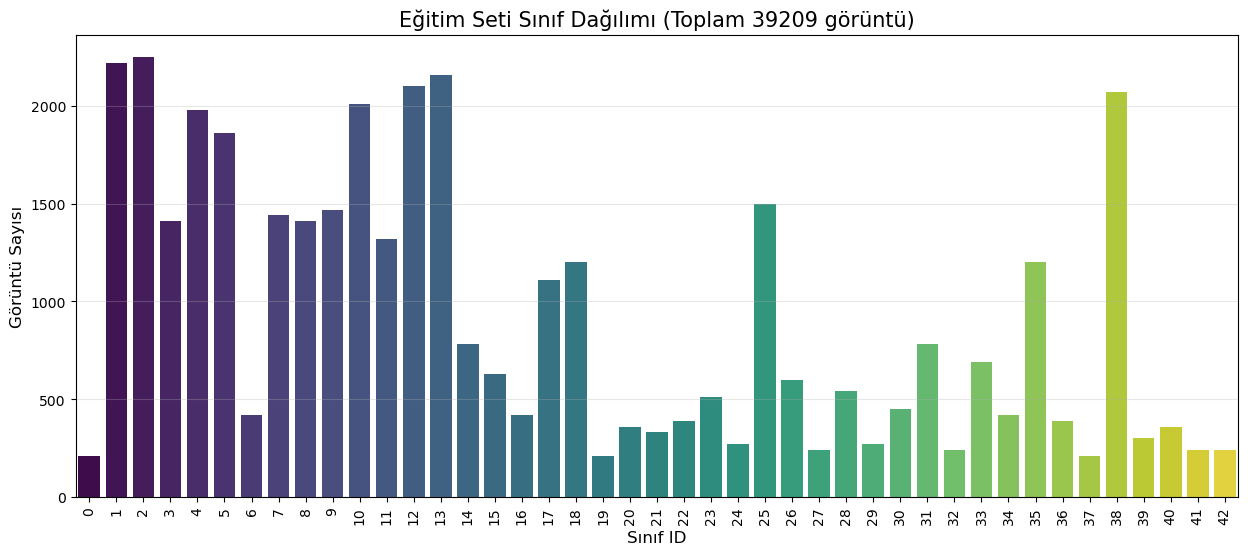


--- İşlenmiş Veriden Rastgele Örnekler ---


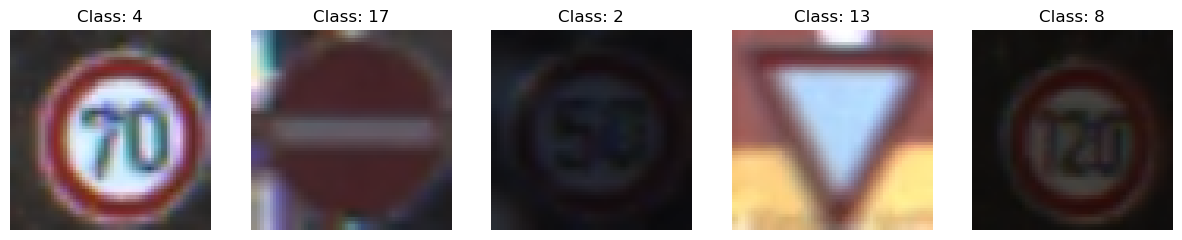

In [ ]:
if 'y_labels_np' in locals():
    # 1. GRAFİK: Sınıf Dağılımı (Bar Plot)
    plt.figure(figsize=(15, 6))
    unique, counts = np.unique(y_labels_np, return_counts=True)
    # Düzeltme burada: x değişkeni 'unique' hue'ya atandı ve legend kapatıldı.
    sns.barplot(x=unique, y=counts, hue=unique, palette="viridis", legend=False) 
    plt.title(f'Eğitim Seti Sınıf Dağılımı (Toplam {len(y_labels_np)} görüntü)', fontsize=15)
    plt.xlabel('Sınıf ID', fontsize=12)
    plt.ylabel('Görüntü Sayısı', fontsize=12)
    plt.xticks(rotation=90)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # 2. GRAFİK: Rastgele Örnekler
    print("\n--- İşlenmiş Veriden Rastgele Örnekler ---")
    plt.figure(figsize=(15, 5))
    indices = np.random.randint(0, len(X_data_np), 5)
    
    for i, idx in enumerate(indices):
        plt.subplot(1, 5, i+1)
        # OpenCV BGR okur, Matplotlib RGB ister. Ancak processed_img zaten normalize (0-1) 
        # ve cv2.imread BGR okuduğu için renkler ters olabilir. 
        # Düzelmek için kanalları terse çeviriyoruz (:: -1)
        img_rgb = X_data_np[idx][:, :, ::-1] 
        plt.imshow(img_rgb)
        plt.title(f"Class: {y_labels_np[idx]}")
        plt.axis('off')
    plt.show()

## BÖLÜM 2: Model Eğitimi (`basic_cnn_model_training.py`)

Oluşturduğumuz `.npy` dosyalarını yükleyip, PyTorch ile CNN modelini eğiteceğiz.

In [ ]:

NUM_CLASSES = 43
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.001

X_FILENAME = f'X_train_processed_{IMG_SIZE[0]}x{IMG_SIZE[1]}.npy'
Y_FILENAME = f'y_train_processed_{IMG_SIZE[0]}x{IMG_SIZE[1]}.npy'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Cihaz kullanılıyor: {device}")

# --- 1. ADIM: VERİ YÜKLEME ---
if os.path.exists(X_FILENAME) and os.path.exists(Y_FILENAME):
    X_np = np.load(X_FILENAME)
    y_np = np.load(Y_FILENAME)
    print(f"Veriler yüklendi.")
else:
    print("HATA: Dosyalar bulunamadı, lütfen yukarıdaki hücreyi çalıştırın.")
    # exit() yerine burada işlemi durdurmak için basit bir flag kullanabiliriz, ama kod akışına devam ediyoruz.

# --- 2. ADIM: SPLIT & TENSOR DÖNÜŞÜMÜ ---
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42, stratify=y_np
)

# (B, H, W, C) -> (B, C, H, W)
X_train = torch.tensor(X_train_np).float().permute(0, 3, 1, 2)
X_val = torch.tensor(X_val_np).float().permute(0, 3, 1, 2)
y_train = torch.tensor(y_train_np).long()
y_val = torch.tensor(y_val_np).long()

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Eğitim Seti: {len(train_dataset)}, Doğrulama Seti: {len(val_dataset)}")

# --- 3. ADIM: MODEL MİMARİSİ ---
class SimpleBatchNormCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(SimpleBatchNormCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleBatchNormCNN(num_classes=NUM_CLASSES).to(device)

# --- 4. ve 5. ADIM: EĞİTİM DÖNGÜSÜ ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("\nModel Eğitimi Başlıyor...")
for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    # Kayıt
    history['train_loss'].append(train_loss / train_total)
    history['train_acc'].append(train_correct / train_total)
    history['val_loss'].append(val_loss / val_total)
    history['val_acc'].append(val_correct / val_total)
    
    print(f"Epoch {epoch+1}: Train Acc: {history['train_acc'][-1]:.4f} | Val Acc: {history['val_acc'][-1]:.4f}")

print("Eğitim Tamamlandı.")

#Kaydet
model_filename = 'traffic_sign_model_batchnorm_cnn_PYTORCH.pth'
torch.save(model.state_dict(), model_filename)
print(f"Model kaydedildi: {model_filename}")

Cihaz kullanılıyor: cpu
Veriler yüklendi.
Eğitim Seti: 31367, Doğrulama Seti: 7842

Model Eğitimi Başlıyor...


Epoch 1: Train Acc: 0.8532 | Val Acc: 0.9883


Epoch 2: Train Acc: 0.9786 | Val Acc: 0.9939


Epoch 3: Train Acc: 0.9846 | Val Acc: 0.9950


Epoch 4: Train Acc: 0.9875 | Val Acc: 0.9952


Epoch 5: Train Acc: 0.9905 | Val Acc: 0.9959


Epoch 6: Train Acc: 0.9914 | Val Acc: 0.9943


Epoch 7: Train Acc: 0.9933 | Val Acc: 0.9966


Epoch 8: Train Acc: 0.9923 | Val Acc: 0.9968


Epoch 9: Train Acc: 0.9947 | Val Acc: 0.9960


Epoch 10: Train Acc: 0.9953 | Val Acc: 0.9980


Epoch 11: Train Acc: 0.9955 | Val Acc: 0.9954


Epoch 12: Train Acc: 0.9953 | Val Acc: 0.9972


Epoch 13: Train Acc: 0.9958 | Val Acc: 0.9969


Epoch 14: Train Acc: 0.9961 | Val Acc: 0.9963


Epoch 15: Train Acc: 0.9959 | Val Acc: 0.9973
Eğitim Tamamlandı.
Model kaydedildi: traffic_sign_model_batchnorm_cnn_PYTORCH.pth


### Eğitim Sonuçlarını Görselleştirme
Eğitim sırasındaki Kayıp (Loss) ve Doğruluk (Accuracy) değişimlerini grafik üzerinde görelim.

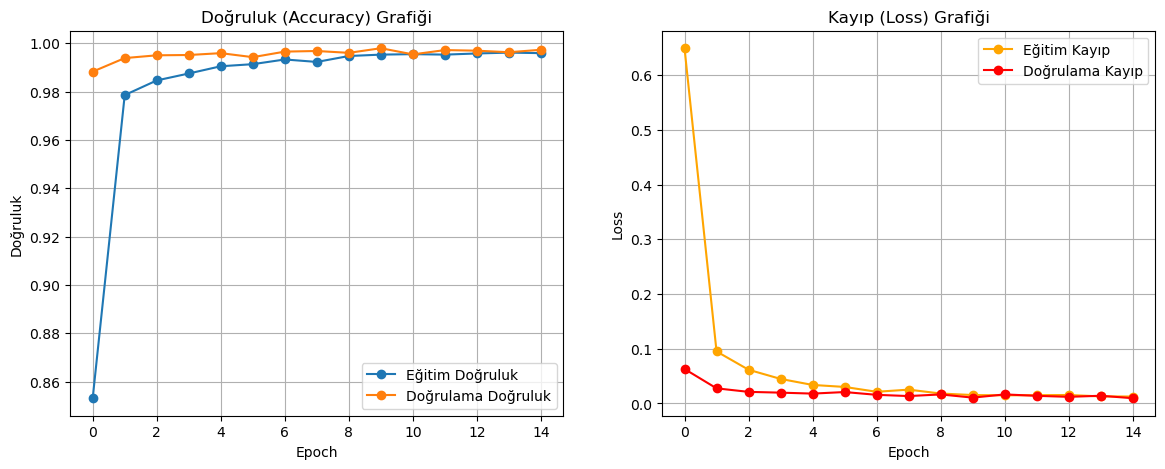

In [6]:
plt.figure(figsize=(14, 5))

# 1. Grafik: Doğruluk
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Eğitim Doğruluk', marker='o')
plt.plot(history['val_acc'], label='Doğrulama Doğruluk', marker='o')
plt.title('Doğruluk (Accuracy) Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# 2. Grafik: Kayıp
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Eğitim Kayıp', marker='o', color='orange')
plt.plot(history['val_loss'], label='Doğrulama Kayıp', marker='o', color='red')
plt.title('Kayıp (Loss) Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

## BÖLÜM 3: Model Testi (`model_test.py`)

Kaydettiğimiz modeli yükleyip, hiç görmediği `Final_Test/Images` verisi üzerinde test edeceğiz.

In [ ]:

MODEL_PATH = 'traffic_sign_model_batchnorm_cnn_PYTORCH.pth' 
TEST_IMAGE_DIR = 'GTSRB_Final_Test/Images'
TEST_CSV_PATH = 'GT-final_test.csv'


# --- TEST VERİSİ YÜKLEME ---
def load_test_data_pytorch(image_dir, csv_path, target_size):
    print("Test verisi yükleniyor...")
    X_test_np = []
    y_test_np = []
    
    if not os.path.exists(csv_path):
        print(f"HATA: CSV bulunamadı: {csv_path}")
        return None, None
        
    df = pd.read_csv(csv_path, sep=';')
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Test İşleniyor"):
        filename = row['Filename']
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)
        if image is None: continue
            
        x1, y1, x2, y2 = int(row['Roi.X1']), int(row['Roi.Y1']), int(row['Roi.X2']), int(row['Roi.Y2'])
        cropped_image = image[y1:y2, x1:x2]
        if cropped_image.shape[0] == 0: continue
            
        resized_image = cv2.resize(cropped_image, target_size)
        normalized_image = resized_image / 255.0
        
        X_test_np.append(normalized_image)
        y_test_np.append(int(row['ClassId']))
    
    X_test_torch = torch.tensor(np.array(X_test_np)).float().permute(0, 3, 1, 2)
    y_test_torch = torch.tensor(np.array(y_test_np)).long()
    
    return X_test_torch, y_test_torch

# --- TEST İŞLEMİ ---
X_test, y_test = load_test_data_pytorch(TEST_IMAGE_DIR, TEST_CSV_PATH, IMG_SIZE)

if X_test is not None:
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Modeli Yükle
    model_test = SimpleBatchNormCNN(num_classes=43).to(device)
    model_test.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model_test.eval()
    
    all_preds = []
    all_labels = []
    
    print("\nTahminler yapılıyor...")
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model_test(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    # Metrikler
    accuracy = (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
    print(f"\nTest Doğruluk (Accuracy): %{accuracy * 100:.2f}")
    
    # Karmaşıklık Matrisi Grafiği
    plt.figure(figsize=(20, 20))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Karmaşıklık Matrisi')
    plt.ylabel('Gerçek')
    plt.xlabel('Tahmin')
    plt.show()
else:
    print("Test verisi yüklenemediği için test yapılamadı.")

Test verisi yükleniyor...


Test İşleniyor: 100%|██████████| 12630/12630 [00:05<00:00, 2471.81it/s]


NameError: name 'SimpleBatchNormCNN' is not defined

### Gerçek Test Görüntüleri Üzerinde Tahminler
Test setinden rastgele görüntüler seçip, modelin bunlar üzerinde ne tahmin ettiğini görselleştirelim.

In [1]:
if X_test is not None:
    # Rastgele 10 index seç
    indices = np.random.randint(0, len(X_test), 10)
    
    plt.figure(figsize=(20, 8))
    
    for i, idx in enumerate(indices):
        # Görüntüyü al (Tensor -> Numpy -> H,W,C formatına çevir)
        img_tensor = X_test[idx]
        img_display = img_tensor.permute(1, 2, 0).numpy()
        # Renkleri düzelt (BGR -> RGB)
        img_display = img_display[:, :, ::-1]
        
        true_label = y_test[idx].item()
        pred_label = all_preds[idx]
        
        # Subplot
        ax = plt.subplot(2, 5, i + 1)
        ax.imshow(img_display)
        
        # Başlık rengi: Doğruysa Yeşil, Yanlışsa Kırmızı
        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f"Gerçek: {true_label}\nTahmin: {pred_label}", color=color, fontsize=12, fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

NameError: name 'X_test' is not defined